# Accidents Analysis in Barcelona


### Imports

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from numpy.random import RandomState



## EDA

In [140]:
csv_dir=r'C:\Users\HP\Desktop\Projects\Reto Hackathon barcelona activa\2023_accidents_causa_conductor_gu_bcn_.csv'
data=pd.read_csv(csv_dir)

In [ ]:
data.head(5)

In [176]:
data.columns.

Index(['Numero_expedient', 'Codi_districte', 'Nom_districte', 'Codi_barri',
       'Nom_barri', 'Codi_carrer', 'Nom_carrer', 'Num_postal ',
       'Descripcio_dia_setmana', 'NK_Any', 'Mes_any', 'Nom_mes', 'Dia_mes',
       'Hora_dia', 'Descripcio_torn', 'Descripcio_causa_mediata',
       'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50', 'Longitud_WGS84',
       'Latitud_WGS84', 'num_accidents', 'num_accidents1', 'num_accidents2'],
      dtype='object')

Numero_expedient tiene una combinacion de numeros letras y espacios, por eso aqui procedo a limpiarla

In [142]:
df['Numero_expedient'].unique()

array(['2023S000699    ', '2023S005197    ', '2023S007430    ', ...,
       '2023S000678    ', '2023S006888    ', '2023S004812    '],
      dtype=object)

In [143]:
# limpiar espacios vacios
df['Numero_expedient'] = df['Numero_expedient'].str.strip() 

# Eliminar 2023S
df['Numero_expedient'] = df['Numero_expedient'].str.replace('2023S', '')

# Convertir a numérico (si es posible)
df['Numero_expedient'] = pd.to_numeric(df['Numero_expedient'], errors='coerce')

# Verificar resultados
print(df['Numero_expedient'].unique())
print(df.isnull().sum())  # Comprobar si hay NaN


[ 699 5197 7430 ...  678 6888 4812]
Numero_expedient            0
Codi_districte              0
Nom_districte               0
Codi_barri                  0
Nom_barri                   0
Codi_carrer                 0
Nom_carrer                  0
Num_postal                  4
Descripcio_dia_setmana      0
NK_Any                      0
Mes_any                     0
Nom_mes                     0
Dia_mes                     0
Hora_dia                    0
Descripcio_torn             0
Descripcio_causa_mediata    0
Coordenada_UTM_X_ED50       0
Coordenada_UTM_Y_ED50       0
Longitud_WGS84              0
Latitud_WGS84               0
dtype: int64


In [144]:
df['Numero_expedient'].unique()

array([ 699, 5197, 7430, ...,  678, 6888, 4812], dtype=int64)

In [145]:
df.head(5)

,Numero_expedient,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Codi_carrer,Nom_carrer,Num_postal,Descripcio_dia_setmana,NK_Any,Mes_any,Nom_mes,Dia_mes,Hora_dia,Descripcio_torn,Descripcio_causa_mediata,Coordenada_UTM_X_ED50,Coordenada_UTM_Y_ED50,Longitud_WGS84,Latitud_WGS84
0,699,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Dissabte,2023,2,Febrer,4,16,Tarda,Manca d'atenció a la conducció,430443.36,4585232.00,2.166596,41.413783
1,5197,-1,Desconegut,-1,Desconegut,-1,Estatut de Catalunya ...,11,Divendres,2023,9,Setembre,1,13,Matí,No respectar distàncies,429493.73,4587108.15,2.155015,41.430598
2,7430,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Divendres,2023,12,Desembre,15,11,Matí,No respectar distàncies,430443.36,4585232.00,2.166596,41.413783
3,961,-1,Desconegut,-1,Desconegut,-1,Amílcar ...,120,Dissabte,2023,1,Gener,28,14,Tarda,No respectat pas de vianants,430955.45,4586335.10,2.172596,41.423762
4,6486,-1,Desconegut,-1,Desconegut,-1,Augusta / Hort de la Vila ...,NaN,Dijous,2023,11,Novembre,2,14,Tarda,Desobeir semàfor,426883.33,4583690.92,2.124189,41.399587


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8897 entries, 0 to 8896
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Numero_expedient          8897 non-null   int64  
 1   Codi_districte            8897 non-null   int64  
 2   Nom_districte             8897 non-null   object 
 3   Codi_barri                8897 non-null   int64  
 4   Nom_barri                 8897 non-null   object 
 5   Codi_carrer               8897 non-null   int64  
 6   Nom_carrer                8897 non-null   object 
 7   Num_postal                8893 non-null   object 
 8   Descripcio_dia_setmana    8897 non-null   object 
 9   NK_Any                    8897 non-null   int64  
 10  Mes_any                   8897 non-null   int64  
 11  Nom_mes                   8897 non-null   object 
 12  Dia_mes                   8897 non-null   int64  
 13  Hora_dia                  8897 non-null   int64  
 14  Descripc

### Tratamiento de nulos

In [147]:
df.isnull().sum()


Numero_expedient            0
Codi_districte              0
Nom_districte               0
Codi_barri                  0
Nom_barri                   0
Codi_carrer                 0
Nom_carrer                  0
Num_postal                  4
Descripcio_dia_setmana      0
NK_Any                      0
Mes_any                     0
Nom_mes                     0
Dia_mes                     0
Hora_dia                    0
Descripcio_torn             0
Descripcio_causa_mediata    0
Coordenada_UTM_X_ED50       0
Coordenada_UTM_Y_ED50       0
Longitud_WGS84              0
Latitud_WGS84               0
dtype: int64

In [148]:
df = df.dropna()

### Duplicados

In [149]:
total_duplicates = df.duplicated().sum()
print(f"Filas duplicadas: {total_duplicates}")


Filas duplicadas: 0


In [150]:
# VAlores no finitos
numeric_columns = df.select_dtypes(include=[np.number])
print(np.isinf(numeric_columns).sum()) 

Numero_expedient         0
Codi_districte           0
Codi_barri               0
Codi_carrer              0
NK_Any                   0
Mes_any                  0
Dia_mes                  0
Hora_dia                 0
Coordenada_UTM_X_ED50    0
Coordenada_UTM_Y_ED50    0
Longitud_WGS84           0
Latitud_WGS84            0
dtype: int64


## Visualizacion de datos

### Accidentes por hora

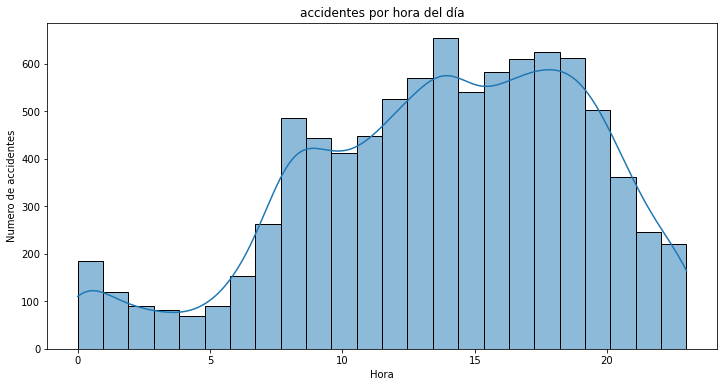

In [151]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Hora_dia'], bins=24, kde=True)
plt.title('accidentes por hora del día')
plt.xlabel('Hora')
plt.ylabel('Numero de accidentes')
plt.show()

### Accidentes por dia de semana

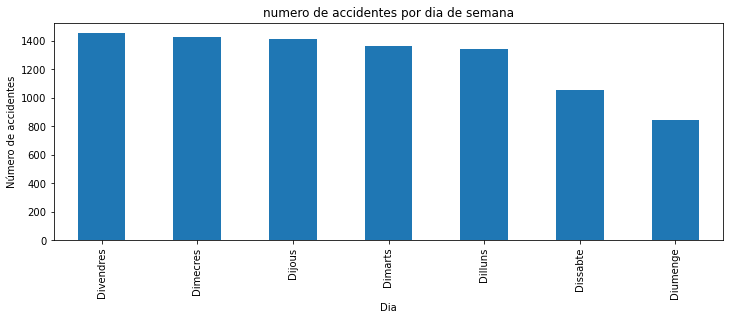

In [152]:
ax1 = df.groupby(["Descripcio_dia_setmana"])['Numero_expedient'].count().sort_values(ascending = False).plot(kind="bar", figsize = (12, 4))

ax1.set_title('numero de accidentes por dia de semana')
ax1.set_xlabel('Dia')
ax1.set_ylabel('Número de accidentes')

plt.show()

### Accidentes por Distrito

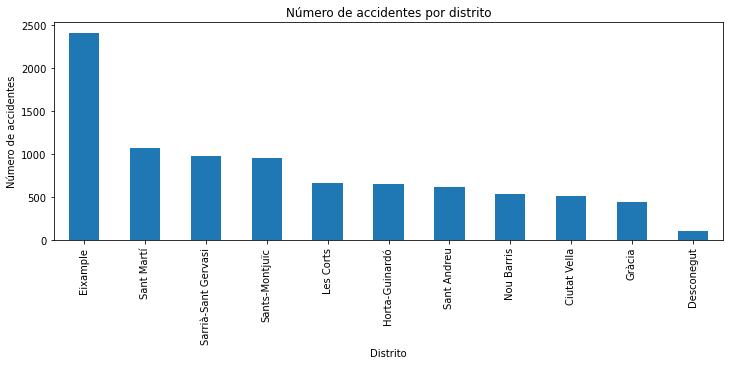

In [153]:
ax2 = df.groupby(["Nom_districte"])['Numero_expedient'].count().sort_values(ascending = False).plot(kind="bar", figsize = (12, 4))

ax2.set_title('Número de accidentes por distrito')
ax2.set_xlabel('Distrito')
ax2.set_ylabel('Número de accidentes')

plt.show()


### Frecuencia de tipos de accidentes

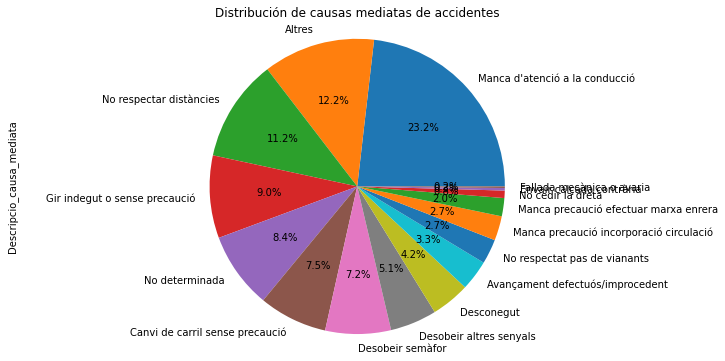

In [154]:
plt.figure(figsize=(12, 6))
df['Descripcio_causa_mediata'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribución de causas mediatas de accidentes')
plt.axis('equal')
plt.show()


### Accidentes por barrio y por distrito

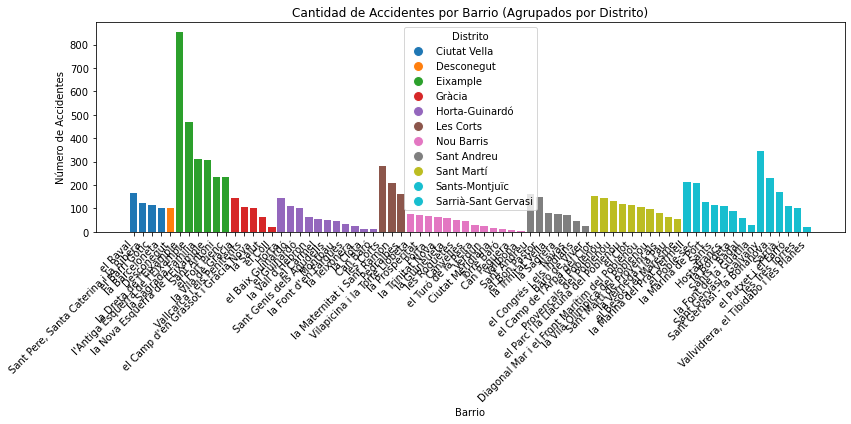

In [155]:
counts = df.groupby(['Nom_districte', 'Nom_barri'])['Numero_expedient'].count().reset_index()

# Ordenar por distrito y número de accidentes
counts = counts.sort_values(by=['Nom_districte', 'Numero_expedient'], ascending=[True, False])

# colores para cada distrito
districts = counts['Nom_districte'].unique()
color_map = plt.get_cmap('tab10')
district_colors = {district: color_map(i) for i, district in enumerate(districts)}

# colores de distritos
counts['Color'] = counts['Nom_districte'].map(district_colors)

# plot
plt.figure(figsize=(12, 6))
bars = plt.bar(counts['Nom_barri'], counts['Numero_expedient'], color=counts['Color'])

# títulos
plt.title('Cantidad de Accidentes por Barrio (Agrupados por Distrito)')
plt.ylabel('Número de Accidentes')
plt.xlabel('Barrio')
plt.xticks(rotation=45, ha='right')
handles = [plt.Line2D([0], [0], marker='o', color='w', label=district,
                       markersize=10, markerfacecolor=district_colors[district]) for district in districts]
plt.legend(handles=handles, title='Distrito')

plt.tight_layout()
plt.show()


---
# Análisis de Insights

Podemos ver que **Eixample** es el distrito con más accidentes, y dentro del mismo, el barrio **La Dreta de Eixample** es el que lidera la tabla.

A su vez, se observa una tendencia en el aumento del número de accidentes en horarios determinados, principalmente desde las **14 a las 20 horas**.

En cuanto a la causa, la **carencia de atención a la conducción** es la principal causa de accidentes.

No parece haber diferencia en la cantidad de accidentes por día de semana, a excepción de una disminución en el número durante los **sábados y domingos**.

---

# Justificación de la selección de features

Basándome en este análisis , considero las **features** más importantes el **distrito** y la **hora del día**, y las selecciono para mi target inicial.

---


In [ ]:
df['num_accidents'] = df.groupby(['Codi_districte', 'Hora_dia'])['Hora_dia'].transform('count')


---

# Reducción de dimensionalidad

Procedo a eliminar las  **coordenadas** porque su información espacial relevante ya esta contenida en  **Codi_districte** y **Codi_barrio**. 
Esto puede ayudar a simplificar el modelo, y reducir el overfitting.



---

# Elección de la variable objetivo

La elección de **Codi_districte** y **Hora_dia** como variables clave para el modelo se justifica por su notable influencia en la ocurrencia de accidentes. El **Codi_districte** proporciona información sobre las áreas geográficas donde se producen los accidentes, permitiendo identificar patrones específicos de cada distrito que pueden estar relacionados con la infraestructura, el tráfico o la densidad poblacional.

Por otro lado, **Hora_dia** permite captar la variación temporal en los accidentes, dado que ciertos períodos del día son más propensos a accidentes debido al aumento del tráfico. La combinación de estas dos variables ofrece una perspectiva comprensiva sobre **cuándo y dónde** es más probable que ocurran los accidentes, lo que las convierte en elementos fundamentales para mejorar la seguridad vial.

---

# Análisis de correlación

Realizo a continuación un análisis de correlación sobre las variables **Codi_districte** y **Hora_dia** para entender las relaciones entre los datos. Primero **factorizo** las variables categoricas, para darles un valor numérico y poder compararlas con las otras variables.

In [ ]:
df['Codi_districte'] = pd.factorize(df['Codi_districte'])[0]
df['Descripcio_dia_setmana'] = pd.factorize(df['Descripcio_dia_setmana'])[0]
df['Descripcio_torn'] = pd.factorize(df['Descripcio_torn'])[0]


In [ ]:
df = df.drop(['Numero_expedient', 'Nom_districte', 'Nom_barri', 'Nom_carrer', 'Num_postal ', 'Longitud_WGS84', 'Latitud_WGS84'], axis=1)


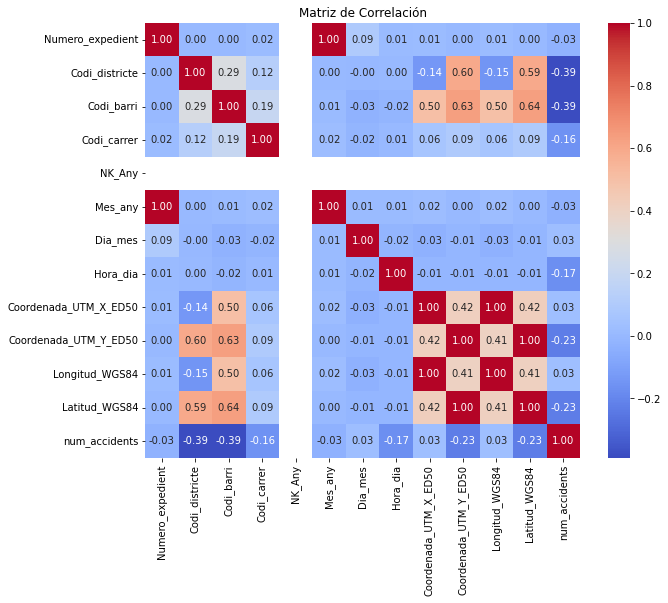

Correlación con num_accidents:
num_accidents            1.000000
Longitud_WGS84           0.033583
Coordenada_UTM_X_ED50    0.030756
Dia_mes                  0.027323
Numero_expedient        -0.030085
Mes_any                 -0.034285
Codi_carrer             -0.158840
Hora_dia                -0.170848
Latitud_WGS84           -0.230297
Coordenada_UTM_Y_ED50   -0.231340
Codi_barri              -0.387743
Codi_districte          -0.389830
NK_Any                        NaN
Name: num_accidents, dtype: float64


In [157]:
correlation_matrix = df.corr()

# Visualizar la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de Correlación")
plt.show()

print("Correlación con num_accidents:")
print(correlation_matrix['num_accidents'].sort_values(ascending=False))

<h1 style="font-size: 15px;">muestra una relación cuantificable entre estas características y el número de accidentes.
    Aunque la correlación con Hora_dia es mas baja, el Codi_districte muestra una correlación mayor</h1>

## Modelado y pipeline

In [ ]:
# division de datos
X = df.drop('num_accidents', axis=1)
y = df['num_accidents']

# columnas numericas y categoricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# definir modelos y pipelines
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# hiperparámetros Random Forest
rf_parametros = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': uniform(0.1, 0.9),
    'regressor__bootstrap': [True, False],
    'regressor__oob_score': [True, False],
    'regressor__max_samples': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Hiperparámetros XGBoost
xgb_parametros = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__max_depth': randint(3, 12),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__min_child_weight': randint(1, 10),
    'regressor__gamma': uniform(0, 0.5),
    'regressor__alpha': uniform(0, 1),
    'regressor__lambda': uniform(0, 1),
    'regressor__scale_pos_weight': uniform(0.5, 1.5)
}

# Busquedade hiperparámetros y entrenamiento
rf = RandomizedSearchCV(rf_pipeline, rf_parametros, n_iter=10, cv=5, n_jobs=-1, random_state=42, error_score='raise')
xgb = RandomizedSearchCV(xgb_pipeline, xgb_parametros, n_iter=10, cv=5, n_jobs=-1, random_state=42, error_score='raise')

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Evaluación
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, mae, mse, rmse

metricas_rf = evaluate_model(rf.best_estimator_, X_test, y_test)
metricas_xgb = evaluate_model(xgb.best_estimator_, X_test, y_test)

print("Metricas Random Forest:", metricas_rf)
print("Metricas XGBoost :", metricas_xgb)

# elegir el mejor modelo
best_model = rf if metricas_rf[0] > metricas_xgb[0] else xgb
print("Mejor modelo:", "RandomForest" if best_model == rf else "XGBoost")

#importancia de características 
importances = best_model.best_estimator_.named_steps['regressor'].feature_importances_

# nombres de características numéricas
numeric_feature_names = numeric_features.tolist()

# Obtener nombres de características de OneHotEncoder
ohe = best_model.best_estimator_.named_steps['preprocessor'].transformers[1][1]
ohe_feature_names = []
for i, cat in enumerate(ohe.categories_):
    for c in cat:
        ohe_feature_names.append(f"{categorical_features[i]}_{c}")

# Combinar nombres de características
feature_names = np.concatenate([numeric_feature_names, ohe_feature_names])

# Crear DataFrame para la importancia de características
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print(feature_importance.head(10))


Lo transformo en una funcion para poder realizar cambios en la variable objetivo con facilidad

In [ ]:
def entrenar_evaluar_modelos(df, target, n_iter=10, test_size=0.2, random_state=42):
 
"""
    Esta función entrena y evalúa con Random Forest y XGBoost

    Args:
    - df: DataFrame 
    - target: columna objetivo a predecir
    - n_iter: numero de iteraciones para buscar hiperparámetros (default 10).
    - test_size: proporcion de datos utilizada para test (default 0.2).
    - random_state: Semilla de números aleatorios (default 42).

    Returns:
    - rf: modelo Random Forest entrenado.
    - xgb: modelo XGBoost entrenado.
    - feature_importance: DataFrame con un ranking de laimportancia de las características de los modelos.
    
    La función hace lo siguiente:
     - Separa los datos en  train y test.
     - Diferencia los tipos de datos segun si son numéricas o categoricas.
     - Construye pipelines para Random Forest y XGBoost.
     - Realiza una RandomizedSearchCV de hiperparámetros para los modelos.
     - Entrena los modelos y calcula el rendimiento utilizando métricas como R^2, MAE y RMSE.
     - Compara los modelos y selecciona el mejor.
     - Calcula las feature importance.
    """
    # División de datos
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Columnas numéricas y categóricas
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
    
    # Definir modelos y pipelines
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=random_state))])
    
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=random_state))])
    
    # Hiperparámetros Random Forest
    rf_parametros = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__max_depth': randint(5, 30),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10),
        'regressor__max_features': uniform(0.1, 0.9),
        'regressor__bootstrap': [True, False],
        'regressor__oob_score': [True, False],
        'regressor__max_samples': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    
    # Hiperparámetros XGBoost
    xgb_parametros = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__max_depth': randint(3, 12),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__subsample': uniform(0.7, 0.3),  
        'regressor__colsample_bytree': uniform(0.6, 0.4), 
        'regressor__min_child_weight': randint(1, 10),
        'regressor__gamma': uniform(0, 0.5),
        'regressor__alpha': uniform(0, 1),
        'regressor__lambda': uniform(0, 1),
        'regressor__scale_pos_weight': uniform(0.5, 1.5)
    }
    
    # Búsqueda de hiperparámetros y entrenamiento
    rf = RandomizedSearchCV(rf_pipeline, rf_parametros, n_iter=n_iter, cv=5, n_jobs=-1, random_state=random_state, error_score='raise')
    xgb = RandomizedSearchCV(xgb_pipeline, xgb_parametros, n_iter=n_iter, cv=5, n_jobs=-1, random_state=random_state, error_score='raise')
    
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Evaluación
    def evaluate_model(model, X_test, y_test):
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        return r2, mae, mse, rmse
    
    metricas_rf = evaluate_model(rf.best_estimator_, X_test, y_test)
    metricas_xgb = evaluate_model(xgb.best_estimator_, X_test, y_test)
    
    print("Métricas Random Forest:", metricas_rf)
    print("Métricas XGBoost:", metricas_xgb)
    
    # Elegir el mejor modelo
    best_model = rf if metricas_rf[0] > metricas_xgb[0] else xgb
    print("Mejor modelo:", "RandomForest" if best_model == rf else "XGBoost")
    
    # Importancia de características
    importances = best_model.best_estimator_.named_steps['regressor'].feature_importances_
    
    # Nombres de características numéricas
    numeric_feature_names = numeric_features.tolist()
    
    # Obtener nombres de características de OneHotEncoder
    ohe = best_model.best_estimator_.named_steps['preprocessor'].transformers_[1][1]
    ohe_feature_names = []
    for i, cat in enumerate(ohe.categories_):
        for c in cat:
            ohe_feature_names.append(f"{categorical_features[i]}_{c}")
    
    # Combinar nombres de características
    feature_names = np.concatenate([numeric_feature_names, ohe_feature_names])
    
    # Crear DataFrame para la importancia de características
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print(feature_importance.head(10))
    
    return rf, xgb, feature_importance



Pruebo con diferentes targets.

In [ ]:
# Target original
df['num_accidents'] = df.groupby(['Codi_districte', 'Hora_dia'])['Hora_dia'].transform('count')
resultados_originales = entrenar_evaluar_modelos(df, 'num_accidents')

# Nuevo target (accidentes por día en cada distrito)
df['num_accidents_diarios'] = df.groupby(['Codi_districte', 'Data'])['Data'].transform('count')
resultados_diarios = entrenar_evaluar_modelos(df, 'num_accidents_diarios')

# Compara los resultados

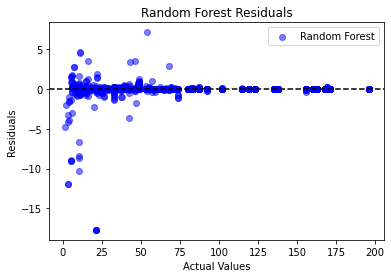

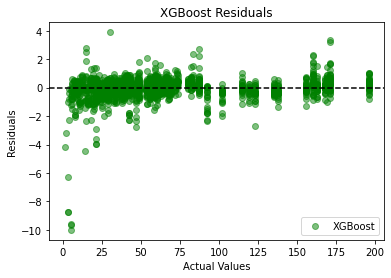

In [173]:
# Calculate residuals
rf_residuals = y_test - rf_test_preds
xgb_residuals = y_test - xgb_test_preds

# Plot Random Forest residuals
plt.scatter(y_test, rf_residuals, color='blue', label='Random Forest', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Random Forest Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Plot XGBoost residuals
plt.scatter(y_test, xgb_residuals, color='green', label='XGBoost', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("XGBoost Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()